<div align="center"> <h1> Section C: Training and Deploying with the AWS SageMaker </h1> </div>
<div align="center"> <h4>  Swastik Nath. </h4> </div>
<div align='center'> <h4> Udacity Machine Learning Engineer Nanodegree Final Capstone</h4> </div> 

<hr></hr>

In order to productionize the idea of the model to the real world, AWS SageMaker is a no-match to anything. In order to deploy the model to the real world, train and deploy with the AWS SageMaker will require an engineering workflow. 
### Importing the Necessary Libraries.

In [63]:
import pandas as pd
import boto3
import sagemaker
import os

### Getting Hold of the AWS SageMaker credentials, Role and Bucket.
The Current SageMaker Session running throughout this notebook and beyond will be much required to get hold of the underlying bucket, execution role and IAM specifics and specific permissions and privillages of the current user.

In [64]:
session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = session.default_bucket()
bucket

'sagemaker-us-west-2-782510500637'

### Uploading to Datasets to S3: This may take significant amount of time because of Large Size of Data.
Clean up of the bucket mentioned above after training the model will be required not to incur additional charges on the AWS Bills or not to exceed the free tier or credits that have been applied to the AWS account. **Once Executed, do not execute it again, as it may incur additional charges. If needed to execute again, please clear the S3 bucket first.**

In [4]:
%%time
data_dir = 'data'
train_prefix = 'train_chest_xray/train'
test_prefix = 'test_chest_xray/test'
#uploading both of these two to S3 for Sagemaker Inference:
train_data = session.upload_data(os.path.join(data_dir, 'workdir'), key_prefix = train_prefix)
test_data = session.upload_data(os.path.join(data_dir, 'testdir'), key_prefix = test_prefix)

Checking whether the Dataset has been uploaded correctly or not. 

In [ ]:
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'

In [6]:
print(train_data)
print(test_data)

s3://sagemaker-us-west-2-782510500637/train_chest_xray
s3://sagemaker-us-west-2-782510500637/test_chest_xray


Once you upload the dataset use the printed the S3 Urls above to reference to the location through different kernel sessions. 

In [65]:
train_data = 's3://sagemaker-us-west-2-782510500637/train_chest_xray'
test_data = 's3://sagemaker-us-west-2-782510500637/test_chest_xray'

### Training the Model with the SageMaker PyTorch Estimator:
Now we train the model with SageMaker's PyTorch Estimator and pass in the location of the training dataset which is available via the **S3 Bucket** connected to this SageMaker Session. The url to the training data has been provided which will be downloaded in the training instance at the time of training and each of the image file will be passed through a cascade of **Torchvision Transformers** which will resize them and convert them to multidimensional tensors upon which our model can perform stochastic calculations, which will then be converted into Deterministic classification.  

**The training process below will require 30-45 minutes on CUDA and might take 2-3 hours on CPU to complete.**

### Training the VGG19 Batch Normalization:
As a base model we will be using VGG19 With Batch Normalization and will fit with our test data by providing the S3 location. We are using a **p2.xlarge** GPU powered EC2 ML instance to power the training process. We are referring to **train.py** available via **sagemaker_scripts** folder as our PyTorch Training Script.

In [99]:
from sagemaker.pytorch import PyTorch
model_prefix = 'chest_xray_model'
chest_xray_pyt = PyTorch(role = role, 
                         entry_point='train.py',
                         source_dir='sagemaker_scripts', 
                         train_instance_count=1,
                         train_instance_type = 'ml.p2.xlarge', 
                         sagemaker_session = session, 
                         framework_version='0.4.0',
                         hyperparameters={
                             'epochs':4
                         }
                        )                        

In [17]:
%%time
chest_xray_pyt.fit({'train':train_data})

2020-04-11 13:38:50 Starting - Starting the training job...
2020-04-11 13:38:51 Starting - Launching requested ML instances......
2020-04-11 13:39:52 Starting - Preparing the instances for training......
2020-04-11 13:41:12 Downloading - Downloading input data.........
2020-04-11 13:42:40 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-11 13:43:02,505 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-11 13:43:02,533 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-11 13:43:02,537 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-11 13:43:02,777 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-04-11 13:43:02,777 sagemaker-containers INFO     Generating setup.cfg
2020-04-11 13:43:02,777 sagemaker-contai

### Tuning Hyperparameters of the VGG19 Batch Normalization:

In [100]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, HyperparameterTuner

objective_metric_name = 'average test loss'
objective_type = 'Minimize'
metric_definitions = [{'Name': 'average test loss',
                       'Regex': 'Test set: Average loss: ([0-9\\.]+)'}]
hyperparameter_ranges = { 
                         'epochs':CategoricalParameter([2, 3, 4, 5]),
                         'lr': ContinuousParameter(0.001, 0.1),
                         'batch-size': CategoricalParameter([20,32, 50, 64,128,256,512])
                        }

In [101]:
!pygmentize 'sagemaker_scripts/train.py'

import argparse
import json
import os
import torch
import logging
import sys
import sagemaker_containers
import torch.optim as optim
import torch.utils.data
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

vgg19_b = torchvision.models.vgg19_bn(pretrained=True)

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

from model import VGG19

def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VGG19(model_info['

In [102]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, HyperparameterTuner

vgg_param_tuner = HyperparameterTuner(chest_xray_pyt,
                            objective_metric_name,
                            hyperparameter_ranges,              
                            metric_definitions,
                            max_jobs=5,
                            max_parallel_jobs=1,
                            objective_type=objective_type )

In [103]:
vgg_param_tuner.fit({'train':train_data, 'validation':test_data})

In [106]:
best_vgg = sagemaker.estimator.Estimator.attach(vgg_param_tuner.best_training_job())

2020-04-12 17:46:51 Starting - Preparing the instances for training
2020-04-12 17:46:51 Downloading - Downloading input data
2020-04-12 17:46:51 Training - Training image download completed. Training in progress.
2020-04-12 17:46:51 Uploading - Uploading generated training model
2020-04-12 17:46:51 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-12 17:21:32,882 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-12 17:21:32,884 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value average test loss to Json.
Returning the value itself
2020-04-12 17:21:32,921 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-12 17:21:35,952 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-12 17:21:36,194 sagemaker-containers INFO     Module 

### Training the Resnet 50:

In [45]:
from sagemaker.pytorch import PyTorch
model_prefix = 'chest_xray_resnet_augmenter'
chest_xray_resnet_aug = PyTorch(role=role, 
                            entry_point='train_resnet.py',
                            source_dir = 'sagemaker_scripts', 
                            train_instance_count=1, 
                            train_instance_type='ml.p2.xlarge', 
                            sagemaker_session=session, framework_version='0.4.0',
                            hyperparameters={
                                'epochs': 4, 
                                'batch-size':50
                            })

In [47]:
chest_xray_resnet_aug.fit({'train':train_data, 'validation':test_data})

2020-04-12 09:52:47 Starting - Starting the training job...
2020-04-12 09:52:48 Starting - Launching requested ML instances......
2020-04-12 09:54:06 Starting - Preparing the instances for training.........
2020-04-12 09:55:23 Downloading - Downloading input data.........
2020-04-12 09:57:10 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-12 09:57:11,573 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-12 09:57:11,599 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-12 09:57:13,017 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-12 09:57:13,246 sagemaker-containers INFO     Module train_resnet does not provide a setup.py. 
Generating setup.py
2020-04-12 09:57:13,246 sagemaker-containers INFO     Generating setup.cfg
2020-0

### Tuning the Hyperparameters for the Resnet 50 model:
We need to tune the hyperparameters of the Resnet 50 model for even greater test accuracy. We will go ahead and invoke the SageMaker Hyperparameter Tuner and tune for a lesser validation loss. We will be using the **lr** and **batch_size** parameters for getting a greater test accuracy. After the hyperparameter tuning job is over we obtain the best training job in the whole training process and we will then train the model with larger epochs. 

In [48]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, HyperparameterTuner

objective_metric_name = 'average test loss'
objective_type = 'Minimize'
metric_definitions = [{'Name': 'average test loss',
                       'Regex': 'Test set: Average loss: ([0-9\\.]+)'}]
hyperparameter_ranges = {
                         'lr': ContinuousParameter(0.001, 0.1),
                         'batch-size': CategoricalParameter([20,32, 50, 64,128,256,512])
                        }

In [49]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, HyperparameterTuner

resnet_param_tuner = HyperparameterTuner(chest_xray_resnet_aug,
                            objective_metric_name,
                            hyperparameter_ranges,              
                            metric_definitions,
                            max_jobs=9,
                            max_parallel_jobs=1,
                            objective_type=objective_type )

The notebook will wait for the Hyperparameter job to finish. Using a **p2.xlarge** instance the tuning job took 2 hours and 37 minutes in total. You might need to change the EBS size of the tuning job machine as large datasets and large CNN architectures may emit out of memory error and may fail 1-2 tuning jobs.

In [ ]:
resnet_param_tuner.fit({'train':train_data, 'validation':test_data})
resnet_param_tuner.wait()

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Now we need to obtain the best training job from the HyperparameterTuner object and attach the training job to a SageMaker Estimator object in order to get the context of the training job.

In [55]:
resnet_param_tuner.best_training_job()

'sagemaker-pytorch-200412-1019-004-7b867e4f'

We use this specific training job name here becuase it gave us the best test accuracy over the test dataset.

In [71]:
best_resnet_tuned = sagemaker.estimator.Estimator.attach(training_job_name='sagemaker-pytorch-200412-1019-001-4668b00c')

2020-04-12 10:42:03 Starting - Preparing the instances for training
2020-04-12 10:42:03 Downloading - Downloading input data
2020-04-12 10:42:03 Training - Training image download completed. Training in progress.
2020-04-12 10:42:03 Uploading - Uploading generated training model
2020-04-12 10:42:03 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-12 10:23:08,064 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-12 10:23:08,065 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value average test loss to Json.
Returning the value itself
2020-04-12 10:23:08,088 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-12 10:23:09,503 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-12 10:23:09,777 sagemaker-containers INFO     Module 

In [80]:
parm = best_resnet_tuned.hyperparameters()
print("Best Batch Size: ", parm['batch-size'])
print("Learning Rate: ", parm['lr'])
best_resnet_tuned.model_data

Best Batch Size:  "32"
Learning Rate:  0.03770470375841778


's3://sagemaker-us-west-2-782510500637/sagemaker-pytorch-200412-1019-001-4668b00c/output/model.tar.gz'

### Training the Resnet Model with best parameters found from the best tuned model for larger epochs:
We now train the Resnet 50 Model again with best parameters from the hyperparameter job for an larger epoch as it emits most less testing loss, we expect it work better if we train it longer.

In [75]:
from sagemaker.pytorch import PyTorch
model_prefix = 'chest_xray_resnet'
chest_xray_resnet = PyTorch(role=role, 
                            entry_point='train_resnet.py',
                            source_dir = 'sagemaker_scripts', 
                            train_instance_count=1, 
                            train_instance_type='ml.p2.xlarge', 
                            sagemaker_session=session, framework_version='0.4.0',
                            hyperparameters={
                                'epochs':5,
                                'lr': 0.03770470375841778,
                                'batch-size': 32
                            })

In [76]:
%%time
chest_xray_resnet.fit({'train':train_data, 'validation':test_data})

2020-04-12 15:13:21 Starting - Starting the training job...
2020-04-12 15:13:23 Starting - Launching requested ML instances......
2020-04-12 15:14:24 Starting - Preparing the instances for training......
2020-04-12 15:15:26 Downloading - Downloading input data.........
2020-04-12 15:17:19 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-12 15:17:20,526 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-12 15:17:20,551 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-12 15:17:21,985 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-12 15:17:22,237 sagemaker-containers INFO     Module train_resnet does not provide a setup.py. 
Generating setup.py
2020-04-12 15:17:22,237 sagemaker-containers INFO     Generating setup.cfg
2020-04-

In [33]:
#if no associated training jobs are found, attach the estimator with a training job. 
# chest_xray_pyt = chest_xray_pyt.attach(training_job_name='sagemaker-pytorch-2020-04-09-21-15-35-146', sagemaker_session=session)
chest_xray_resnet = chest_xray_resnet.attach(training_job_name='sagemaker-pytorch-2020-04-11-19-18-31-113', sagemaker_session=session)

2020-04-11 19:41:55 Starting - Preparing the instances for training
2020-04-11 19:41:55 Downloading - Downloading input data
2020-04-11 19:41:55 Training - Training image download completed. Training in progress.
2020-04-11 19:41:55 Uploading - Uploading generated training model
2020-04-11 19:41:55 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-11 19:22:34,200 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-11 19:22:34,228 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-11 19:22:34,233 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-11 19:22:34,458 sagemaker-containers INFO     Module train_resnet does not provide a setup.py. 
Generating setup.py
2020-04-11 19:22:34,458 sagemaker-containers INFO     Generating setup.cfg
2020-04-11 19:22:34,459 sagemake

## Deployment Section:
We now implement Data Capture Configuration for our endpoint to capture 70% of the data being fed to the model and saves it to the specified bucket location so that we can actually capture data from the users and can use that data later to update our model later. 

In [36]:
# Creating provisions for Automatic Data Capture :
from time import gmtime, strftime
prefix = 'auto_data_capture'
data_capture_prefix = '{}/datacapture'.format(prefix)
s3_capture_upload_path = 's3://{}/{}'.format(bucket, data_capture_prefix)
reports_prefix = '{}/reports'.format(prefix)
s3_report_path = 's3://{}/{}'.format(bucket,reports_prefix)

from sagemaker.model_monitor import DataCaptureConfig
endpoint_name = 'chest-xray-with-data-capt-'+strftime("%Y-%m-%d-%H-%M-%S", gmtime())

data_capture_config = DataCaptureConfig(enable_capture=True, 
                                        sampling_percentage=70, 
                                        destination_s3_uri=s3_capture_upload_path)

In [19]:
%%time
predictor = chest_xray_pyt.deploy(initial_instance_count=1,
                                  instance_type='ml.m4.xlarge', 
                                  endpoint_name = endpoint_name, 
                                  data_capture_config=data_capture_config)

---------------!CPU times: user 259 ms, sys: 13.6 ms, total: 272 ms
Wall time: 7min 31s


In [38]:
predictor_resnet = chest_xray_resnet.deploy(initial_instance_count=1, 
                                           instance_type='ml.m4.xlarge',
                                           endpoint_name=endpoint_name)

Using already existing model: sagemaker-pytorch-2020-04-11-19-18-31-113


-----------!

In [12]:
predictor_aug = chest_xray_resnet_aug.deploy(initial_instance_count=1, 
                            instance_type='ml.m4.xlarge')

-------------!

In [91]:
from sagemaker.predictor import RealTimePredictor, json_deserializer

class ImagePredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(endpoint_name, 
                                             sagemaker_session, 
                                             deserializer=json_deserializer, 
                                             content_type='application/x-image', 
                                             accept='application/json')

In [92]:
from sagemaker.pytorch import PyTorchModel
realtime_endpoint = PyTorchModel(model_data=best_resnet_tuned.model_data, 
                                 role=role, entry_point='predict.py', 
                                 source_dir='sagemaker_scripts', 
                                 predictor_cls=ImagePredictor)

In [93]:
realtime_endpoint.deploy(initial_instance_count=1, 
                         instance_type='ml.m4.xlarge')

-------------!

### Performing Inference via the Deployed Endpoint over the Test Dataset:
The following block of code may take significant amount of time as it goes ahead and sends out one single image at a time from the test dataset and performs inference over it and compares both of their labels and calculates overall accuracy. As there are 32 batches in total with 20 images per batch, so it's a time hungry process.

In [39]:
%%time
from torchvision import transforms, datasets
import torch
test_dir = 'data/testdir'
image_transformer = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
test_data = datasets.ImageFolder(test_dir, transform=image_transformer)
batch_size=20
num_workers=0
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          num_workers=num_workers, 
                                          shuffle=True)
dataiter = iter(test_loader)
predictions = []
labels_target = []
for ii in range(len(dataiter)-1):
    images, labels = dataiter.next()
    for i in range(len(images)-1):
        pred = predictor_resnet.predict(images[i].unsqueeze_(0))
        pred = pred.argmax()
        predictions.append(pred)
        targ = labels.data[i].item()
        labels_target.append(targ)
from sklearn.metrics import accuracy_score
acc = accuracy_score(predictions, labels_target)
print("Test Accuracy is : ")
print(acc)

Test Accuracy is : 
0.801358234295416
CPU times: user 24.1 s, sys: 656 ms, total: 24.8 s
Wall time: 2min 44s


### Performing Inference over the test dataset using the base VGG19 Batch Normalization.

In [26]:
%%time
from torchvision import transforms, datasets
import torch
test_dir = 'data/testdir'
image_transformer = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
test_data = datasets.ImageFolder(test_dir, transform=image_transformer)
batch_size=20
num_workers=0
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          num_workers=num_workers, 
                                          shuffle=True)
dataiter = iter(test_loader)
predictions = []
labels_target = []
for ii in range(len(dataiter)-1):
    images, labels = dataiter.next()
    for i in range(len(images)-1):
        pred = predictor.predict(images[i].unsqueeze_(0))
        pred = pred.argmax()
        predictions.append(pred)
        targ = labels.data[i].item()
        labels_target.append(targ)
from sklearn.metrics import accuracy_score
acc = accuracy_score(predictions, labels_target)
print("Test Accuracy is : ")
print(acc)

Test Accuracy is : 
0.8030560271646859
CPU times: user 31.3 s, sys: 1.07 s, total: 32.4 s
Wall time: 9min 10s


### Performing inference over a single input image:
In order to perfrom the inference over input images the images need to go thorough a series of transformation steps like it needs to be transformed into PIL images then it needs to be resized to 224x224 and after that it needs to be transformed into a tensor. As we feed the model endpoint the transformed image as a multidimensional tensor it returns back probabilities of the input being one of the three classes. We deterministically choose the class using **argmax**.

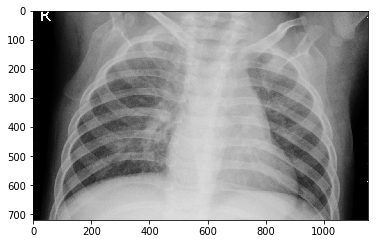

Viral Pneumonia Diagnosed
Inference Latency is : 1.1727867126464844 seconds

In [27]:
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
import sys
%matplotlib inline
import time
classes = ['Bacterial Pneumonia Diagnosed', 
           'Pneumonia Not Diagnosed', 
           'Viral Pneumonia Diagnosed']
s_time = time.time()
im = cv2.imread(os.path.join('data/testdir/virus', os.listdir(os.path.join('data/testdir', 'virus'))[60]))
plt.imshow(im, cmap = 'gray')
image_transformer = transforms.Compose([transforms.ToPILImage(), transforms.Resize((224, 224)), transforms.ToTensor()])
im = image_transformer(im)
pred = predictor.predict(im.unsqueeze_(0))
plt.show()
sys.stderr.write(classes[pred.argmax()])
sys.stderr.write("\nInference Latency is : %s seconds" %(time.time() - s_time))

### Cleaning the AWS Account:
We need to clean up all the endpoints that might be running in the background in order not to incur additional charges. So, we delete all the endpoints, empty S3 bucket and stop all the notebook instances.  

In [139]:
predictor.delete_endpoint()

In [34]:
predictor_resnet.delete_endpoint()

In [ ]:
predictor_resnet_aug.delete_endpoint()